# GLM-HMM analyses

### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ssm
from utils import *

#temp workaround since it gets removed from the path whenever the kernel is restarted
import sys
sys.path.insert(0, '/Users/gabriel/lib/')
import chiCa

%matplotlib widget

### Define some functions

In [2]:
def get_session_dates(file_names):
    session_dates = []
    for file in file_names:
        split_path = file.split('/')
        session_dates.append(split_path[5]) #with the churchland data folder structure, this corresponds to the date

    return session_dates

def get_session_averages(file_names, min_stims=5):
    session_performance_averages = []
    for file in file_names: 
        session_data = pd.read_hdf(file)
        stim_rates = np.unique(np.array([len(timestamps) for timestamps in session_data.stimulus_event_timestamps]))
        if len(stim_rates)>min_stims:
            performance = np.array(session_data.outcome_record, dtype=float)
            performance[performance == -1] = np.nan #setting early withdrawal trials as nans
            performance[performance == 2] = np.nan #setting no response trials as nans
            session_performance_averages.append(np.nanmean(performance))

    return session_performance_averages

def get_filtered_session_averages_and_dates(file_names, min_stims=5):
    filtered_dates = []
    filtered_session_averages = []
    stims = []
    for file in file_names:
        session_data = pd.read_hdf(file)
        stim_rates = np.array([len(timestamps) for timestamps in session_data.stimulus_event_timestamps])
        unique_stims = list(np.unique(stim_rates))
        valid_trials = np.logical_or(stim_rates == 4, stim_rates == 20)
        if len(unique_stims)>min_stims:
            #allocate performance
            performance = np.array(session_data.outcome_record, dtype=float)
            performance[performance == -1] = np.nan #setting early withdrawal trials as nans
            performance[performance == 2] = np.nan #setting no response trials as nans
            filtered_session_averages.append(np.nanmean(performance[valid_trials]))

            #allocate date
            split_path = file.split('/')
            filtered_dates.append(split_path[5])

            #allocate unique_stims
            stims.append(unique_stims)

    return filtered_dates, filtered_session_averages, stims

def get_file_names(animal_name, data_type, file_extension, file_keyword=None):
    '''Tool to select specified files of a data type over all sessions for a given animal.
    This relies on the hierarchical Churchland lab data folder structure with:
    animal_name -> session_datetime -> data_type
    
    Adapted from Lukas Oesch's `chipmunk_analysis_tools.py`.
       
    
    Parameters
    ----------
    animal_name: str, the name of the animal whose sessions are to be selected.
    data_type: str, the directory with the specific data type, for example chipumnk, caiman, etc.
    file_extension: str, file extension specifier, for example *.mat
    file_keyword: str, a pattern that should be detected inside the file name to
                  distinguish the desired files from other files with the same extension.
    
    Returns
    -------
    file_names: list, list of file names selected
    
    Examples
    --------
    file_names = get_file_names('GRB001', 'chipmunk', '*.h5')
    '''
    import os
    import glob
    
    home_dir = os.path.expanduser("~")
    session_dirs = glob.glob(f"{home_dir}/data/{animal_name}/*/")
    
    file_names = []
    for session_dir in session_dirs:
        data_type_dir = os.path.join(session_dir, data_type)
        file_paths = glob.glob(os.path.join(data_type_dir, file_extension))
        for file_path in file_paths:
            if file_keyword is None or file_keyword in file_path:
                file_names.append(file_path)
    
    file_names.sort()
    
    return file_names

def count_stimulus_timestamps(row):
    data = pd.read_hdf(row['path'])
    stimulus_event_timestamps = data['stimulus_event_timestamps']
    trial_lengths = [len(trial) for trial in stimulus_event_timestamps]
    return trial_lengths

def get_response_side(row):
    data = pd.read_hdf(row['path'])
    response_side = np.array(data['response_side'])
    return response_side

def get_filtered_performance_data(paths_all_animals, performance_threshold, min_stims):
    group_performance_data = {}

    for animalID, paths in paths_all_animals.items():
        session_dates, session_averages, unique_stims = get_filtered_session_averages_and_dates(paths, min_stims=min_stims)
        performance_by_day = pd.DataFrame(data={'date':session_dates,'performance average':session_averages, 'unique stims':unique_stims})
        group_performance_data.update({animalID:performance_by_day})

    filtered_group_performance_data = {}

    for animal_id, performance_data in group_performance_data.items():
        filtered_performance_data = performance_data[performance_data['performance average'] >= performance_threshold].reset_index(drop=True)
        filtered_dates = filtered_performance_data['date'].tolist()
        filtered_paths = []
        for path in paths_all_animals[animal_id]:
            if '/' in path:
                split_path = path.split('/')
                if split_path[5] in filtered_dates:
                    filtered_paths.append(path)
        filtered_group_performance_data[animal_id] = {'performance data': filtered_performance_data, 'filtered paths': filtered_paths}

    filtered_data_list = []

    for animal_id, data in filtered_group_performance_data.items():
        filtered_data_list.append(data['performance data'])

    concatenated_data = pd.concat(filtered_data_list, keys=filtered_group_performance_data.keys())
    concatenated_data = concatenated_data.reset_index().rename(columns={'level_0': 'animal_id', 'level_1': 'row_index'})

    filtered_paths = []
    for animal_id, animal_data in filtered_group_performance_data.items():
        for filtered_path in animal_data['filtered paths']:
            filtered_paths.append([animal_id, filtered_path])

    df_filtered_paths = pd.DataFrame(filtered_paths, columns=['animalID', 'path'])

    df_filtered_paths['data'] = df_filtered_paths['path'].apply(pd.read_hdf)
    df_filtered_paths['trials_per_session'] = df_filtered_paths['data'].apply(len)
    df_filtered_paths['num_completed_trials'] = df_filtered_paths['data'].apply(lambda x: len(x[x['outcome_record'].isin([-1, 2]) == False]))
    df_filtered_paths['stimuli_presented'] = df_filtered_paths.apply(count_stimulus_timestamps, axis=1)
    df_filtered_paths['response_side'] = df_filtered_paths.apply(get_response_side, axis=1)
    df_filtered_paths['choice'] = df_filtered_paths['response_side'].apply(lambda x: [val for val in x if not pd.isna(val)])
    
    all_data = df_filtered_paths

    return all_data

### Filter out bad sessions

In [3]:
#Get performance averages for each session
GRB001_paths = get_file_names('GRB001', 'chipmunk', '*.h5')
GRB002_paths = get_file_names('GRB002', 'chipmunk', '*.h5')
GRB003_paths = get_file_names('GRB003', 'chipmunk', '*.h5')
GRB004_paths = get_file_names('GRB004', 'chipmunk', '*.h5')

paths_all_animals = {'GRB001':GRB001_paths,
                     'GRB002':GRB002_paths,
                     'GRB003':GRB003_paths,
                     'GRB004':GRB004_paths}

all_data = get_filtered_performance_data(paths_all_animals=paths_all_animals, performance_threshold=0.7, min_stims=5)

## MLE GLM-HMM

In [4]:
# Set the parameters of the GLM-HMM
num_states = 3        # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2         # input dimensions

# Make a GLM-HMM
glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

### Creating external input sequences

In [5]:
num_sess = len(all_data) # number of example sessions
num_trials_per_sess = all_data['num_completed_trials'].tolist() # number of trials in a session
stim_vals = [4,6,8,10,12,14,16,18,20]

inpts = []
for i in range(num_sess):
    inpts.append(np.ones((num_trials_per_sess[i], 2), dtype=float))

stimuli = all_data['stimuli_presented']
for i in range(num_sess):
    for j in range(num_trials_per_sess[i]):
        inpts[i][j][0] = stimuli[i][j]

choice = [np.array(lst).reshape(-1, 1).astype(int) for lst in  all_data['choice']]

### Fit glmhmm

In [6]:
N_iters = 200 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = glmhmm.fit(choice, inputs=inpts, method="em", num_iters=N_iters, tolerance=10**-4)

  0%|          | 0/200 [00:00<?, ?it/s]

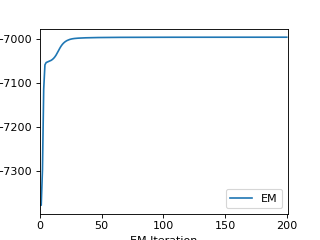

In [7]:
# Plot the log probabilities of the true and fit models. Fit model final LL should be greater 
# than or equal to true LL.
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fit_ll, label="EM")
# plt.plot([0, len(fit_ll)], true_ll * np.ones(2), ':k', label="True")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, len(fit_ll))
plt.ylabel("Log Probability")
plt.show()

### Recover weights

Text(0.5, 1.0, 'Weight recovery')

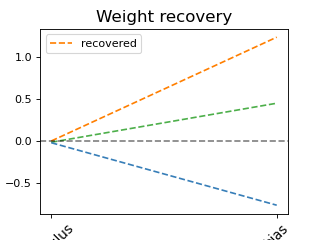

In [8]:
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
cols = ['#ff7f00', '#4daf4a', '#377eb8']
recovered_weights = glmhmm.observations.params
for k in range(num_states):
    if k ==0:
        plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = "recovered", linestyle = '--')
    else:
        plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = '', linestyle = '--')
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("Weight recovery", fontsize=15)

### Plot transition matrix

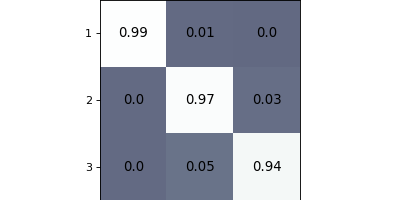

In [9]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')


recovered_trans_mat = np.exp(glmhmm.transitions.log_Ps)
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("recovered", fontsize = 15)
plt.subplots_adjust(0, 0, 1, 1)


### Get posterior probabilities

In [10]:
# Get expected states:
posterior_probs = [glmhmm.expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip(choice, inpts)]

Text(0, 0.5, 'p(state)')

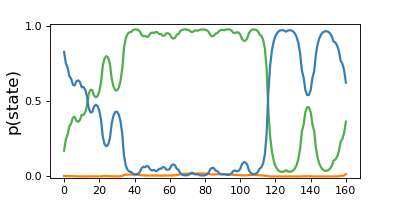

In [11]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
sess_id = 0 #session id; can choose any index between 0 and num_sess-1
for k in range(num_states):
    plt.plot(posterior_probs[sess_id][:, k], label="State " + str(k + 1), lw=2,
             color=cols[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlabel("trial #", fontsize = 15)
plt.ylabel("p(state)", fontsize = 15)

### Get state occupancies

In [12]:
# concatenate posterior probabilities across sessions
posterior_probs_concat = np.concatenate(posterior_probs)
# get state with maximum posterior probability at particular trial:
state_max_posterior = np.argmax(posterior_probs_concat, axis = 1)
# now obtain state fractional occupancies:
_, state_occupancies = np.unique(state_max_posterior, return_counts=True)
state_occupancies = state_occupancies/np.sum(state_occupancies)

Text(0, 0.5, 'frac. occupancy')

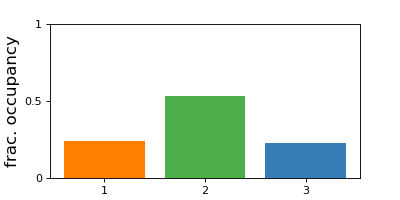

In [13]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
for z, occ in enumerate(state_occupancies):
    plt.bar(z, occ, width = 0.8, color = cols[z])
plt.ylim((0, 1))
plt.xticks([0, 1, 2], ['1', '2', '3'], fontsize = 10)
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
plt.xlabel('state', fontsize = 15)
plt.ylabel('frac. occupancy', fontsize=15)

## MAP GLM-HMM

In [14]:
# Instantiate GLM-HMM and set prior hyperparameters
prior_sigma = 2
prior_alpha = 2
map_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
             observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
             transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))

In [15]:
# Fit GLM-HMM with MAP estimation:
_ = map_glmhmm.fit(choice, inputs=inpts, method="em", num_iters=N_iters, tolerance=10**-4)

  0%|          | 0/200 [00:00<?, ?it/s]

In [16]:
# true_likelihood = true_glmhmm.log_likelihood(true_choices, inputs=inpts)
mle_final_ll = glmhmm.log_likelihood(choice, inputs=inpts) 
map_final_ll = map_glmhmm.log_likelihood(choice, inputs=inpts) 

Text(0, 0.5, 'loglikelihood')

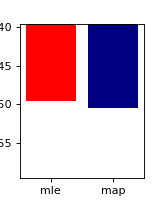

In [17]:
# Plot these values
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
loglikelihood_vals = [mle_final_ll, map_final_ll]
colors = ['Red', 'Navy']
for z, occ in enumerate(loglikelihood_vals):
    plt.bar(z, occ, width = 0.8, color = colors[z])
plt.ylim((mle_final_ll-10, mle_final_ll+10))
plt.xticks([0, 1], ['mle', 'map'], fontsize = 10)
plt.xlabel('model', fontsize = 15)
plt.ylabel('loglikelihood', fontsize=15)

## Cross-validation

In [18]:
# Create additional input sequences to be used as held-out test data
# num_test_sess = 10
# test_inpts = np.ones((num_test_sess, num_trials_per_sess, input_dim)) 
# test_inpts[:,:,0] = np.random.choice(stim_vals, (num_test_sess, num_trials_per_sess)) 
# test_inpts = list(test_inpts)

#######

# num_sess = len(all_data) # number of example sessions
# num_trials_per_sess = all_data['num_completed_trials'].tolist() # number of trials in a session
# stim_vals = [4,6,8,10,12,14,16,18,20]

# inpts = []
# for i in range(num_sess):
#     inpts.append(np.ones((num_trials_per_sess[i], 2), dtype=float))

# stimuli = all_data['stimuli_presented']
# for i in range(num_sess):
#     for j in range(num_trials_per_sess[i]):
#         inpts[i][j][0] = stimuli[i][j]

# choice = [np.array(lst).reshape(-1, 1).astype(int) for lst in  all_data['choice']]

#######

num_test_sess = 10 # number of example sessions
num_trials_per_test_sess = all_data['num_completed_trials'][:num_test_sess].tolist() # number of trials in a session
stim_vals = [4,6,8,10,12,14,16,18,20]

test_inpts = []
for i in range(num_test_sess):
    test_inpts.append(np.ones((num_trials_per_test_sess[i], 2), dtype=float))

test_stimuli = all_data['stimuli_presented'][:num_test_sess]
for i in range(num_test_sess):
    for j in range(num_trials_per_test_sess[i]):
        test_inpts[i][j][0] = stimuli[i][j]

test_choice = [np.array(lst).reshape(-1, 1).astype(int) for lst in all_data['choice'][:num_test_sess]]

In [19]:
# Compare likelihood of test_choices for model fit with MLE and MAP:
mle_test_ll = glmhmm.log_likelihood(test_choice, inputs=test_inpts) 
map_test_ll = map_glmhmm.log_likelihood(test_choice, inputs=test_inpts) 

Text(0, 0.5, 'loglikelihood')

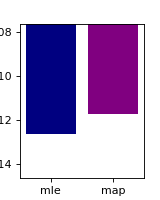

In [20]:
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
loglikelihood_vals = [mle_test_ll, map_test_ll]
colors = ['Navy', 'Purple']
for z, occ in enumerate(loglikelihood_vals):
    plt.bar(z, occ, width = 0.8, color = colors[z])
plt.ylim((mle_test_ll-2, mle_test_ll+5))
plt.xticks([0, 1], ['mle', 'map'], fontsize = 10)
plt.xlabel('model', fontsize = 15)
plt.ylabel('loglikelihood', fontsize=15)

Text(0.5, 1.0, 'MAP')

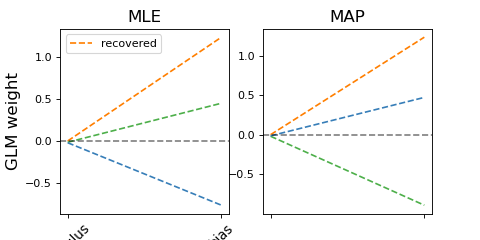

In [21]:
fig = plt.figure(figsize=(6, 3), dpi=80, facecolor='w', edgecolor='k')
cols = ['#ff7f00', '#4daf4a', '#377eb8']
plt.subplot(1,2,1)
recovered_weights = glmhmm.observations.params
for k in range(num_states):
    if k ==0: # show labels only for first state
        plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = 'recovered', linestyle='--')   
    else:
        plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = '', linestyle='--')
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.title("MLE", fontsize = 15)
plt.legend()

plt.subplot(1,2,2)
recovered_weights = map_glmhmm.observations.params
for k in range(num_states):
    plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                 lw=1.5,  label = '', linestyle='--')
plt.yticks(fontsize=10)
plt.xticks([0, 1], ['', ''], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.title("MAP", fontsize = 15)

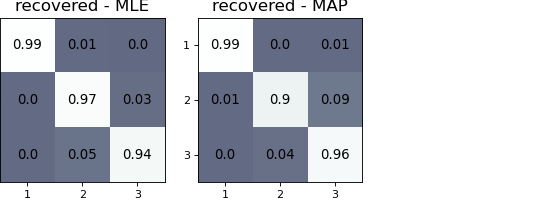

In [22]:
fig = plt.figure(figsize=(7, 2.5), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 3, 1)
recovered_trans_mat = np.exp(glmhmm.transitions.log_Ps)
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("recovered - MLE", fontsize = 15)
plt.subplots_adjust(0, 0, 1, 1)


plt.subplot(1, 3, 2)
recovered_trans_mat = np.exp(map_glmhmm.transitions.log_Ps)
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("recovered - MAP", fontsize = 15)
plt.subplots_adjust(0, 0, 1, 1)

## Exploring the HMM object

In [27]:
dir(glmhmm)

['D',
 'K',
 'M',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_fit_em',
 '_fit_sgd',
 '_fit_stochastic_em',
 'expected_log_likelihood',
 'expected_log_probability',
 'expected_states',
 'filter',
 'fit',
 'init_state_distn',
 'initialize',
 'log_likelihood',
 'log_prior',
 'log_probability',
 'most_likely_states',
 'observations',
 'params',
 'permute',
 'sample',
 'smooth',
 'transitions']

In [44]:
# # Set the parameters of the GLM-HMM
# num_states = 3        # number of discrete states
# obs_dim = 1           # number of observed dimensions
# num_categories = 2    # number of categories for output
# input_dim = 2         # input dimensions

# # Make a GLM-HMM
# glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
#                    observation_kwargs=dict(C=num_categories), transitions="standard")

####

# D is the number of observed dimensions
# K is the number of states
# M is the number of input dimensions
# C is the number of output categories
glmhmm.observations??

Type:           InputDrivenObservations
String form:    <ssm.observations.InputDrivenObservations object at 0x1041a7370>
File:           ~/lib/ssm/ssm/observations.py
Source:        
class InputDrivenObservations(Observations):

    def __init__(self, K, D, M=0, C=2, prior_mean = 0, prior_sigma=1000):
        """
        @param K: number of states
        @param D: dimensionality of output
        @param C: number of distinct classes for each dimension of output
        @param prior_sigma: parameter governing strength of prior. Prior on GLM weights is multivariate
        normal distribution with mean 'prior_mean' and diagonal covariance matrix (prior_sigma is on diagonal)
        """
        super(InputDrivenObservations, self).__init__(K, D, M)
        self.C = C
        self.M = M
        self.D = D
        self.K = K
        self.prior_mean = prior_mean
        self.prior_sigma = prior_sigma
        # Parameters linking input to distribution over output classes
        self.Wk = np